### COO Assessment - Question 3

- We are given the Prisoner's Dilemma as a Bargaining Problem
- The Prisoners’ Dilemma is a famous model for illustrating the conflict between social cooperation and self-interested behavior.
- We first import the necessary packages needed for this problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import *
from math import *

- Consider a two player Prisoners’ Dilemma.
- The cooperative payoff possibilities are mathematically described by a polytope which is defined
as the convex hull of the payoff vectors (4,4), (6,0), (0,6) and (0,0).
- We plot this convex hull for the problem below

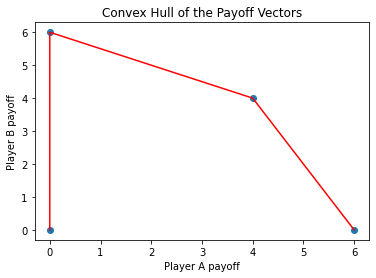

In [2]:
# We are going to model the Prisoner's Dilemma game using CVXPY
# The game is played between two players, A and B
# We are given that cooperative payoff possibilities are mathematically described by a polytope which is defined as the convex hull of the payoff vectors (4,4), (6,0), (0,6) and (0,0).

# Define the payoff vectors
payoff_vectors = np.array([[4,4],[6,0],[0,6],[0,0]])

# Define the convex hull of the payoff vectors
convex_hull = np.array([[0,0],[0,6],[4,4],[6,0]])

# Plot the payoff vectors and the convex hull
plt.plot(payoff_vectors[:,0], payoff_vectors[:,1], 'o')
plt.plot(convex_hull[:,0], convex_hull[:,1], 'r-')
plt.xlabel('Player A payoff')
plt.ylabel('Player B payoff')
plt.title('Convex Hull of the Payoff Vectors')
plt.show()

- We think of the Prisoner's Dilemma as a Bargaining situation with the disagreement point as $d = (d_1, d_2)$

- The notion of a disagreement point introduces a constraint that player $i$ cannot get a payoff below her disagreement point payoff $d_i$

- Upon modelling this situation given to us, we are presented with the following constraints:
$$
u_1 + 2u_2 \leq 12
$$
$$
u_2 + 2u_1 \leq 12
$$
$$
u_1 \geq d_1
$$
$$
u_2 \geq d_2
$$

- where $(u_1, u_2)$ is the payoff vectors for the two players in the bargaining situation.
- The constraints given above define the feasible set ($F$) for our constrained optimisation problem which we are going to solve in the forthcoming questions.

#### Question 3

- In this question, keeping the feasible set the same we need to maximise the Nash Welfare Criterion defined as:
$$
N(u_1, u_2) = \log(u_1-d_1) + \log(u_2-d_2) 
$$

- The Nash Bargaining Solution of the Bargaining Problem (i.e. our Objective Function) is given by:
$$
\max_{(u_1, u_2)} N(u_1, u_2)
$$
$$
such \space that \space (u_1, u_2) \in F
$$

- The disagreement point given to us is:
$$
(d_1, d_2) = (2, 1)
$$

In [3]:
# Initialising the disagreement point given to us
d = np.array([2, 1])
d1 = d[0]
d2 = d[1]

- We define the constraints for our problem

In [4]:
# We define the constraints for the problem
def constraint1(u):
    u1 = u[0]
    u2 = u[1]
    return 12 - u1 - 2*u2 

def constraint2(u):
    u1 = u[0]
    u2 = u[1]
    return 12 - 2*u1 - u2 

def constraint3(u):
    u1 = u[0]
    return u1 - d1

def constraint4(u):
    u2 = u[1]
    return u2 - d2

#### Log Barrier Technique

- Since we are not allowed to use the CVXPY library, we implement the Interior Point Algorithm in this problem to solve our inequality constrained convex optimisation problem described.

- The Interior Point Algorithm uses the Log Barrier Method to handle the inequalities.

- The Function with the inequalities is written as (where m is the number of inequality constraints):
$$
B(x) = \sum_{i=1}^{m} (-(\log(-f_{i}(x))))
$$
- where $f_{i}(x) \leq 0$

- If our objective function is defined as $f_{0}(x)$, our combined objective function without any constraints becomes:
$$
\phi(x) = t*f_{0}(x) + B(x) 
$$

- In our case, the log barrier function $B(x)$ is equal to:
$$
B(u_1, u_2) = -[\log(-(2u_2 + u_1 - 12)) + \log(-(2u_1 + u_2 - 12)) + \log(-(d_1 - u_1)) + \log(-(d_2 - u_2))]
$$

- Since we use Newton Descent for finding the minimum of a unconstrained function and we find to maximise the Nash Welfare Criterion, we simply minimise its negative. Therefore our objective function becomes:
$$
\min_{(u_1, u_2)} \space -\log(u_1 - d_1) - \log(u_2 - d_2)
$$

- Thus, $f_{0}(u_1, u_2)$ is equal to $-\log(u_1 - d_1) - \log(u_2 - d_2)$

- Hence our final unconstrained minimisation problem $N(u_1, u_2)$ is:
$$
\min_{(u_1, u_2)} \space t*f_{0}(u_1, u_2) + B(u_1, u_2)
$$

- We first define this as a function in our code


In [5]:
# We define the objective function with the inequality constraints handled using the log barrier function
def Nash(u, t):
    u1 = u[0]
    u2 = u[1]

    # Try except done to handle negative infinity penalty of the log barrier function
    try:
        return -(np.log((12-2*u2-u1)*(12-2*u1-u2)*(u1-d1)*(u2-d2))/t) - np.log((u1-d1)*(u2-d2))
    except:
        return -1e-20

- For the gradient, we need expressions for the partial derivates of $N(u_1, u_2)$ wrt $u_1$ and $u_2$:
$$
\frac{\partial N}{\partial u_1} = \frac{-1-t}{u_1 - d_1} + \frac{1}{12 - 2u_2 - u_1} + \frac{2}{12 - 2u_1 - u_2}
$$

$$
\frac{\partial N}{\partial u_2} = \frac{-1-t}{u_2 - d_2} + \frac{2}{12 - 2u_2 - u_1} + \frac{1}{12 - 2u_1 - u_2}
$$

- Thus the gradient of f(x,y) is a vector of the form:

$$
\nabla N = \begin{vmatrix} 
\frac{\partial N}{\partial u_1} \\
\\
\frac{\partial N}{\partial u_2}
\end{vmatrix}
$$

In [6]:
# We define the gradient of the objective function
def grad_Nash(u, t):
    u1 = u[0]
    u2 = u[1]
    try:
        dg_du1 = ((-1-t)/(u1-d1)) + (1/(12-2*u2-u1)) + (2/(12-2*u1-u2))
        dg_du2 = ((-1-t)/(u2-d2)) + (2/(12-2*u2-u1)) + (1/(12-2*u1-u2))
    except:
        dg_du1 = 1e-20
        dg_du2 = 1e-20
    
    return np.array([dg_du1, dg_du2])

- For the Hessian Matrix, we need the double partial derivates with respect to u_1 and u_2. Calculated them as follows:
$$ 
\frac{\partial^{2} N}{\partial u_{1}^2} = \frac{1+t}{(u_1 - d_1)^{2}} - \frac{1}{(12 - 2u_2 - u_1)^2} - \frac{4}{(12 - 2u_1 - u_2)^2} 
$$

$$ 
\frac{\partial^{2} N}{\partial u_{1}u_{2}} = \frac{\partial^{2} N}{\partial u_{2}u_{1}} = \frac{-2}{(12 - 2u_2 - u_1)^2} - \frac{2}{(12 - 2u_1 - u_2)^2} 
$$

$$ 
\frac{\partial^{2} N}{\partial u_{2}^2} = \frac{1+t}{(u_2 - d_2)^{2}} - \frac{4}{(12 - 2u_2 - u_1)^2} - \frac{1}{(12 - 2u_1 - u_2)^2} 
$$

- Thus the Hessian Matrix of the given function $N(u_1, u_2)$ at any $(u_1, u_2)$ will be:
$$
H(x,y) = \begin{vmatrix} 
\frac{\partial^{2} N}{\partial u_{1}^2}    \frac{\partial^{2} N}{\partial u_{1}u_{2}} \\
\\
\frac{\partial^{2} N}{\partial u_{2}u_{1}}     \frac{\partial^{2} N}{\partial u_{2}^2} 
\end{vmatrix}

In [7]:
# We define the Hessian of the objective function
def hess_Nash(u1, u2, t):
    try:
        d2g_d2u1 = (-1/(12-2*u2-u1)**2) - (4/(12-2*u1-u2)**2) + ((t+1)/((u1-d1)**2))
        d2g_d2u2 = (-4/(12-2*u2-u1)**2) - (1/(12-2*u1-u2)**2) + ((t+1)/((u2-d2)**2))
        d2g_du1_du2 = -2/(12-2*u2-u1)**2 - 2/(12-2*u1-u2)**2
    except:
        d2g_d2u1 = 1e-20
        d2g_d2u2 = 1e-20
        d2g_du1_du2 = 1e-20
    
    return np.array([[d2g_d2u1, d2g_du1_du2], [d2g_du1_du2, d2g_d2u2]])

- We implement the Backtracking Line Search for finding the step-size of the Newton Descent with constants as follows:
$$
\alpha = 0.1 \\
\beta = 0.3 \\
\epsilon = 10^{-5} \space (tolerance)
$$

In [8]:
# Defining the Backtracking Line Search
def linear_search(d, alpha, beta, point, t):
    x = point[0]
    y = point[1]
    step_size = 1
    grad = grad_Nash(x, y, t)
    while (Nash(x + step_size*d[0], y + step_size*d[1], t) > Nash(x, y, t) + alpha*beta*step_size*np.dot(grad, d)):
        step_size *= beta
    return step_size


- We define the Newton Descent Method

In [9]:
# Function to check if a matrix is positive definite
def is_pos_def(x):

    # For checking if a matrix is positive definite we check if all the eigenvalues are positive (applicable for symmetric matrices)
    return np.all(np.linalg.eigvals(x) > 0)

# Implementing the Newton Descent Method
def newton_descent(x0, y0, t, alpha, beta, epsilon, max_iters):
    # Initialize the variables
    x = x0
    y = y0

    #Initializing the loop
    while (np.linalg.norm(grad_Nash(x, y, t)) > epsilon) and (max_iters != 0):
        
        # Compute the gradient
        grad = grad_Nash(x, y, t)

        # Compute the Hessian
        hess = hess_Nash(x, y, t)
            
        # Combination Descent Condition:
        if(is_pos_def(hess)):

            # If the Hessian is positive definite, we use the Newton Step
            
            # Computing the inverse of the Hessian
            hess_inverse = np.linalg.inv(hess)

            # Computing the Newton Step by taking the negative of the Hessian inverse dotted with the gradient vector
            d = -np.dot(hess_inverse, grad)
        
        else:
            
            # If the Hessian is not positive definite, we use the Gradient Descent Step which is the negative of the gradient vector
            d = -grad
        
        # Compute the step size
        step_size = linear_search(d, alpha, beta, [x,y], t)

        # Update the variables
        x = x + step_size*d[0]
        y = y + step_size*d[1]

        # Update the number of iterations
        max_iters = max_iters - 1

    # Return the solution as a numpy array with the number of iterations it took and the coordinates of the solution point
    return np.array([x, y, max_iters])

#### Implementation of Interior Point Algorithm
- Here we implement the Interior Point Algorithm from scratch.
- We pass the initial guess for the primal point as an array:
$$
u = (u_1, u_2) = (3, 3)
$$
- We initially choose the following constants:
$$
t = 1 \\
\mu = 15
$$

- We iterate as we try to solve the minimisation problem with our given initial point and updating $u_1$ and $u_2$ accordingly.

- We update the value of $t$ and keep on incrementing till we achieve the KKT optimality conditions which is:
$$
\frac{m}{t} < \epsilon
$$
- where $\epsilon$ is the tolerance ($10^{-5}$) and $m$ is the number of inequality constraints i.e. $4$ here.

- We return the final values of $u_1$, $u_2$ and $t$ from this algorithm

In [10]:
# Interior Point Algorithm Implementation
def interior_point(u, t, mu, max_iter, tol, m):

    # Initialize the primal points
    u1 = u[0]
    u2 = u[1]

    # Iterate until the maximum number of iterations is reached
    while(max_iter != 0):

        # Check if the accuracy is good enough
        if(m / t < tol):
            break
        
        # Prepare the initial guess for the primal points
        u = np.array([u1, u2])

        # Compute new primal point using Newton Descent Method
        #ress = newton_descent(u1, u2, t, 0.1, 0.3, tol, 1000)

        res = minimize(Nash, u, args = (t,), method='SLSQP', 
                                constraints=[{'type': 'ineq', 'fun': constraint1},
                                            {'type': 'ineq', 'fun': constraint2},
                                            {'type': 'ineq', 'fun': constraint3},
                                            {'type': 'ineq', 'fun': constraint4}])

        # Update the primal points
        primal_point = res.x
        u1 = primal_point[0]
        u2 = primal_point[1]
        
        # We increase accuracy
        t = t*(1 + (1.0)/(10*np.sqrt(mu)))

        # Update the number of iterations
        max_iter = max_iter - 1
    
    # Return the solution as a numpy array with the final value of t and the coordinates of the solution point
    return np.array([u1, u2, t])


- Here we define the constants and call the interior point algorithm on them

In [11]:
# Initial constants

# Maximum number of iterations
max_iter = 1000

# Tolerance
tol = 1e-5

# Initial value of t
t_init = 1 

# Number of constraints
m = 4 

# Initial values of the primal points
u1 = 3
u2 = 3
u = np.array([u1, u2])

# Accuracy multiplier
mu = 10 

# Call the interior point algorithm
solution = interior_point(u, t_init, mu, max_iter, tol, m)

/var/folders/c9/s8062nf53sv0b6gfv3ct0lv80000gn/T/ipykernel_83708/3826924504.py:8: RuntimeWarning: divide by zero encountered in log
  return -(np.log((12-2*u2-u1)*(12-2*u1-u2)*(u1-d1)*(u2-d2))/t) - np.log((u1-d1)*(u2-d2))
/var/folders/c9/s8062nf53sv0b6gfv3ct0lv80000gn/T/ipykernel_83708/3826924504.py:8: RuntimeWarning: invalid value encountered in log
  return -(np.log((12-2*u2-u1)*(12-2*u1-u2)*(u1-d1)*(u2-d2))/t) - np.log((u1-d1)*(u2-d2))


- Here we print the initial and final value of $t$

In [12]:
# Extract the solution
u1 = solution[0]
u2 = solution[1]
t_final = solution[2]

# Initial and Final value of t
print("Initial value of t: ", t_init)
print("Final value of t: ", t_final)

Initial value of t:  1
Final value of t:  408491.17153674125


- Here we print the final bargaining solution for the problem $(u_1, u_2)$:

In [13]:
# Print the solution
print("The bargaining solution is: ")
print("u1 = ", u1)
print("u2 = ", u2)

The bargaining solution is: 
u1 =  4.000007900982537
u2 =  3.9999722225484375


- The solution for this problem thus is approximately:
$$
(u_1, u_2) = (4, 4)
$$

- We put these values in the Nash Welfare Criterion:
$$
\log(u_1 - d_1) + \log(u_2 - d_2)
$$
- to get the Maximised Nash Welfare or the Primal Optimal Value

In [14]:
# The Nash Welfare Criterion
print("The Maximised Nash Welfare (Primal Optimal Value) is: ")
print(log(u1 - d1) + log(u2 - d2))

The Maximised Nash Welfare (Primal Optimal Value) is: 
1.791754160518133


- Thus the maximised Nash Welfare is approximately equal to $1.79$

- Here we print the inequality constraint function values at the optimum $(u_1, u_2)$

In [15]:
print("Constraint 1: 2u1 + u2 <= 12")
print("Constraint 2: u1 + 2u2 <= 12")
print("Constraint 3: u1 >= d1")
print("Constraint 4: u2 >= d2")

print()
# Printing the constraint values
print("The constraint values are: ")
print("Constraint 1: ", constraint1((u1, u2)))
print("Constraint 2: ", constraint2((u1, u2)))
print("Constraint 3: ", constraint3((u1, u2)))
print("Constraint 4: ", constraint4((u1, u2)))

Constraint 1: 2u1 + u2 <= 12
Constraint 2: u1 + 2u2 <= 12
Constraint 3: u1 >= d1
Constraint 4: u2 >= d2

The constraint values are: 
Constraint 1:  4.765392058825313e-05
Constraint 2:  1.1975486489124165e-05
Constraint 3:  2.0000079009825367
Constraint 4:  2.9999722225484375


- The dual optimum variables corresponding to each constraint is given by:
$$
\lambda_{i} = \frac{-1}{t*f_{i}{(x)}}
$$

- where $f_{i}{(x)}$ refers to the $i^{th}$ inequality constraint as defined above also.
- and $t$ refers to final value of $t$ from the Interior Point Algorithm

In [16]:
# Computing the dual optimums corresponding to each constraint
lambda1 = (1)/(t_final*constraint1((u1, u2)))
lambda2 = (1)/(t_final*constraint2((u1, u2)))
lambda3 = (1)/(t_final*constraint3((u1, u2)))
lambda4 = (1)/(t_final*constraint4((u1, u2)))

# Printing the dual optimums
print("The dual optimums are: ")
print("lambda1 = ", lambda1)
print("lambda2 = ", lambda2)
print("lambda3 = ", lambda3)
print("lambda4 = ", lambda4)


The dual optimums are: 
lambda1 =  0.05137107907600213
lambda2 =  0.2044203653057368
lambda3 =  1.2240118259623078e-06
lambda4 =  8.160186632465232e-07
